# MNIST Classifier - Hello World of DL - GPU LOCAL!
<hr/>

## Introduction

This notebook is suffixed with __LEVEL_HERO_DEMO__ because it is deployable high performant ML classifier for the [MNIST](https://paperswithcode.com/dataset/mnist) dataset. This set is presented by your instructor during the lecture. Please confer to the lecture notes for further details.

This notebook is a __demonstration notebook__ to: 
- test your DEV environment,
- show you how developing a ML model can be very simple,
- show you how a simple MLP can achieve quite-human performance in the simple task of recognizing hand-written digits.

>__WARNING__: This notebook requires a GPU to work well. Please switch to the CPU version if you don't have any GPU installed.

## Imports

In [24]:
import os
import time
import idx2numpy
import numpy as np ; np.random.seed(42)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf ; tf.random.set_seed(42)

from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from mpl_toolkits.axes_grid1 import ImageGrid

## Hardware

In [25]:
CPUS = tf.config.list_physical_devices('CPU')
GPUS = tf.config.list_physical_devices('GPU')

print("[INFO] Num CPUs:", len(CPUS), ", list = ", CPUS)
print("[INFO] Num GPUs:", len(GPUS), ", list = ", GPUS)

[INFO] Num CPUs: 1 , list =  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[INFO] Num GPUs: 0 , list =  []


## Notebook parameters

In [26]:
# NumPy

np.set_printoptions(linewidth=200) # to enlarge the print() line
np.random.seed(42) # the random seed init
np.set_printoptions(precision=3) # for numpy floats: number of decimals

# TF: disable TF debug logging messages 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Globals & hyperparameters

In [27]:
# =============
# DATA_TOPDIR
# =============

# Contain the (un)compressed idx files of MNIST

# on assieoussou (Laptop - CPU)
DATA_TOPDIR = "/home/ml/datasets/mnist"

# on cocoti (Tour - GPU)
# DATA_TOPDIR = "/data/ml/datasets/mnist"

# =======
# MNIST 
# =======

# dataset files
TRAIN_IMAGES_DATASET_FILE = os.path.join(DATA_TOPDIR, "train-images-idx3-ubyte")
assert os.path.exists(TRAIN_IMAGES_DATASET_FILE)

TRAIN_LABELS_DATASET_FILE = os.path.join(DATA_TOPDIR, "train-labels-idx1-ubyte")
assert os.path.exists(TRAIN_LABELS_DATASET_FILE)

TEST_IMAGES_DATASET_FILE = os.path.join(DATA_TOPDIR, "t10k-images-idx3-ubyte")
assert os.path.exists(TEST_IMAGES_DATASET_FILE)

TEST_LABELS_DATASET_FILE = os.path.join(DATA_TOPDIR, "t10k-labels-idx1-ubyte")
assert os.path.exists(TEST_LABELS_DATASET_FILE)

print(TRAIN_IMAGES_DATASET_FILE)
print(TRAIN_LABELS_DATASET_FILE)
print(TEST_IMAGES_DATASET_FILE)
print(TEST_LABELS_DATASET_FILE)

# The MNIST images format
num_pixels = 28 * 28

# the total number of digits
num_classes = 10

# ==========================
# Training hyperparameters
# ==========================

epochs = 10 # <= CPU/GPU

# batch_size = 8 # <= on CPU
batch_size = 64 # <= on GPU

# =======
# Demo 
# =======

# Demo dir: where demonstration images are placed
DEMO_DIR = os.path.join(DATA_TOPDIR, "demo")
os.makedirs(DEMO_DIR, exist_ok=True)

# for demo images 
nb_demo = 10
demo_prefix = "demo_img_"


## Data Preparation (Part I)

>__Note:__ In this notebook, all the steps regarding the understanding of the data are skipped. Indeed, in practice Data Scientist spend __80%__ of their time here!



In [28]:
# 1. Read each dataset into a conventional numpy 2D array
train_x_ndarray = idx2numpy.convert_from_file(TRAIN_IMAGES_DATASET_FILE)
train_y_ndarray = idx2numpy.convert_from_file(TRAIN_LABELS_DATASET_FILE)

test_x_ndarray = idx2numpy.convert_from_file(TEST_IMAGES_DATASET_FILE)
test_y_ndarray = idx2numpy.convert_from_file(TEST_LABELS_DATASET_FILE)

(60000, 28, 28) (60000,)
train_x_ndarray[0] = 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18

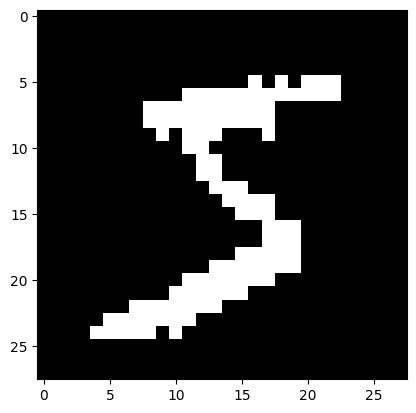

In [29]:
# quick check 
print(train_x_ndarray.shape, train_y_ndarray.shape) # => (60000, 28, 28) (60000,)
print(f"train_x_ndarray[0] = \n{train_x_ndarray[0]}, \ntrain_y_ndarray[0] = {train_y_ndarray[0]}" )
print(train_x_ndarray[0].shape, train_y_ndarray[0].shape) # => (28, 28) ()

# load and display as b&w
# plt.imshow(train_x_ndarray[0], cmap='gray')  # RGB
plt.imshow(Image.fromarray(train_x_ndarray[0]).convert('1'), cmap='gray')

## Model construction & configuration

>__Note:__ In this notebook, all the steps regarding the (best) model selection and evaluation are skipped. We propose directly the best model architecture: a __Convolutional Neural Network (CNN)__ 

In [30]:
def build_model():
    model = Sequential()
    # =================================
    # Feature extractor
    # =================================
    model.add(Input(shape=(28,28,1))),
    model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2))),
    model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2))),
    # =================================
    # Neck
    # =================================
    model.add(Flatten()),
    model.add(Dropout(0.5))
    # =================================
    # Head 
    # =================================
    model.add(Dense(units=num_classes, activation="softmax"))
    # =================================
    # Compile model
    # =================================
    model.compile(loss="categorical_crossentropy", 
                  # optimizer="adam",
                  optimizer=tf.keras.optimizers.Adam(1e-3),
                  metrics=["accuracy"])
    return model

# Construct the model and show it
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

## Data Preparation (Part II)

>__Important:__  Since we know our target ML model now, we need to finalize the preparation of our data according this model (see the Input layer defined by `Input(shape=(28,28,1))`). We need to make sure the training data match this shape!

In [31]:
X_train = train_x_ndarray.astype('float32')
X_test = test_x_ndarray.astype('float32')

# make sure you are not introducing nan
X_train = np.nan_to_num(X_train, nan=0)
X_test = np.nan_to_num(X_test, nan=0)

# normalization: VERY IMPORTANT!!!!
X_train = X_train / 255
X_test = X_test / 255

# one hot encoding of labels
y_train = to_categorical(train_y_ndarray)
y_test = to_categorical(test_y_ndarray)
num_classes = y_train.shape[1]

# before reshaping
print("[INFO] before reshaping >>> ", X_train.shape, X_train[0].shape, y_train.shape, X_test.shape, y_train.shape)
print("[INFO] before reshaping >>> ",X_train[0], y_train[0])

[INFO] before reshaping >>>  (60000, 28, 28) (28, 28) (60000, 10) (10000, 28, 28) (60000, 10)
[INFO] before reshaping >>>  [[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.

In [32]:
# Explicit reshaping of training and testing data to (28, 28, 1)

# WARNING: 
# Here, we could have rely on implicit broadcasting of TF Keras to not reshape and let ate of shape (28, 28) to be automatically 
# reshaped into (28, 28, 1) ; bit it is a bad practice!

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
print("[INFO] After reshaping >>> ", X_train.shape, X_train[0].shape, y_train.shape, X_test.shape, y_train.shape)

[INFO] After reshaping >>>  (60000, 28, 28, 1) (28, 28, 1) (60000, 10) (10000, 28, 28, 1) (60000, 10)


## Model Training & Evaluation

__Construct the demonstration set__

Here, we isolate in the `demo/` subdirectory, some testing images. We'll use them later on - once our model is trained - to demonstrate how accurate it is. 

In [33]:
def reconstruct_demo_dir(nb, from_set, target_dir):
    # randomly collect the indices
    demo_rnd_indices = np.random.randint(1, high=len(from_set), size=nb)
    for i in demo_rnd_indices:
        plt.imsave(os.path.join(target_dir, demo_prefix + str(i) + ".jpg"), from_set[i], cmap='gray')
    print(f"[INFO] {len(demo_rnd_indices)} images have been created in {target_dir}")        

# check if the demo dir exists and contains at least nb_demo files

if os.path.exists(DEMO_DIR): 
    nb_files = len([name for name in os.listdir(DEMO_DIR) if os.path.isfile(os.path.join(DEMO_DIR, name))])
    if nb_files < nb_demo:
        # So you can safely manually add demo file 
        reconstruct_demo_dir(nb=nb_demo, from_set=test_x_ndarray, target_dir=DEMO_DIR)
    else:
        print(f"[INFO] Nothing to do because {DEMO_DIR} contains already enough images!")
else: 
    reconstruct_demo_dir(nb=nb_demo, from_set=test_x_ndarray, target_dir=DEMO_DIR)

[INFO] Nothing to do because /home/ml/datasets/mnist/demo contains already enough images!


__Test some demo images before training__

[INFO] Load demo images as Black'n White... 


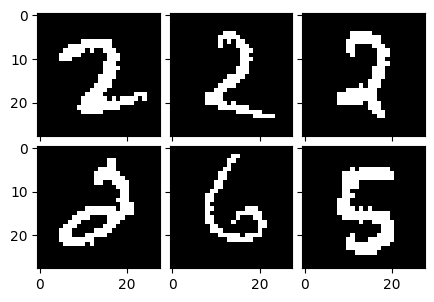

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
[INFO] Prédictions:
 digit: 0 	 -  digit: 0 	 -  digit: 0 	 - 
 digit: 0 	 -  digit: 6 	 -  digit: 0 	 - 



In [34]:
nb_imgs = 6
nb_rows = 2
nb_cols = 3

# load as b&w images
print("[INFO] Load demo images as Black'n White... ")
demo_imgs = [Image.open(os.path.join(DEMO_DIR, name)).convert('1') for name in os.listdir(DEMO_DIR)[:nb_imgs]]

fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(nb_rows, nb_cols),
    axes_pad=0.1,
)

for ax, img in zip(grid, demo_imgs):
    ax.imshow(img)
plt.show()

# Now let's predict

demo_imgs_arrays = np.array([
    np.asarray(demo_img).reshape(demo_img.size[0], demo_img.size[1], 1) 
    for demo_img in demo_imgs
]) 
raw_predictions = model.predict(demo_imgs_arrays)

refined_predictions = []
for rp in raw_predictions:
    refined_predictions.append(np.argmax(rp))

print("[INFO] Prédictions:")

msg_pred = ""
cpt = 0
for i in range(nb_rows):
    for j in range(nb_cols):
        msg_pred += f" digit: {refined_predictions[cpt]} \t - "
        cpt += 1
    msg_pred += "\n"
    
print(msg_pred)

In [10]:
# Remind the hyperparameters values

t1 = time.time()

print("[INFO]")
print("[INFO] ======================= ")
print("[INFO] Hyperparameters")
print("[INFO] ======================= ")
print("[INFO]")
print(f"[INFO] batch_size = {batch_size}")
print(f"[INFO] epochs = {epochs}")

print("[INFO]")
print("[INFO] ======================= ")
print("[INFO] Train & Evaluate")
print("[INFO] ======================= ")
print("[INFO]")

# Fit the model
history = model.fit(
    x=X_train, 
    y=y_train,
    batch_size=batch_size,
    validation_data=(X_test, y_test), 
    epochs=epochs
)

t2 = time.time()
print(f"[INFO] Duration = {t2-t1} seconds.")

# Note: 
# During the fit, monitor the GPUs activity using: $ watch -n 0.5 nvidia-smi

[INFO]
[INFO] ======================= 
[INFO] Hyperparameters
[INFO] ======================= 
[INFO]
[INFO] batch_size = 64
[INFO] epochs = 10
[INFO]
[INFO] ======================= 
[INFO] Train & Evaluate
[INFO] ======================= 
[INFO]
Epoch 1/10


I0000 00:00:1741621112.644918   36955 service.cc:148] XLA service 0x77a3c00092c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741621112.645012   36955 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
I0000 00:00:1741621112.645016   36955 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-03-10 15:38:32.668439: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741621112.760777   36955 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-10 15:38:33.052666: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,32,26,26]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=

 81/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4624 - loss: 1.6933

I0000 00:00:1741621113.964186   36955 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


924/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8289 - loss: 0.5575

2025-03-10 15:38:36.319743: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,26,26]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-10 15:38:36.343916: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,13,13]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8302 - loss: 0.5531

2025-03-10 15:38:37.316350: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,32,26,26]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-10 15:38:37.339649: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,13,13]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8303 - loss: 0.5528 - val_accuracy: 0.9774 - val_loss: 0.0719
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9701 - loss: 0.0979 - val_accuracy: 0.9837 - val_loss: 0.0503
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9774 - loss: 0.0741 - val_accuracy: 0.9850 - val_loss: 0.0438
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9819 - loss: 0.0610 - val_accuracy: 0.9865 - val_loss: 0.0388
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9842 - loss: 0.0525 - val_accuracy: 0.9870 - val_loss: 0.0369
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9853 - loss: 0.0480 - val_accuracy: 0.9881 - val_loss: 0.0324
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9868 - loss: 0.0425 - val_accuracy: 0.9898 - val_loss: 0.0292
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9875 - loss: 0.0411 - val_accuracy: 0.9899 - val_

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


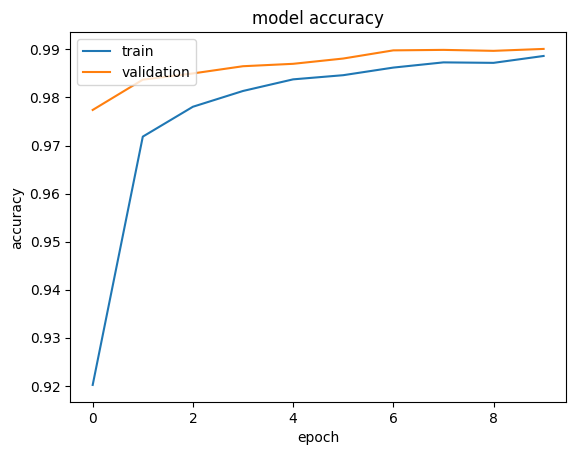

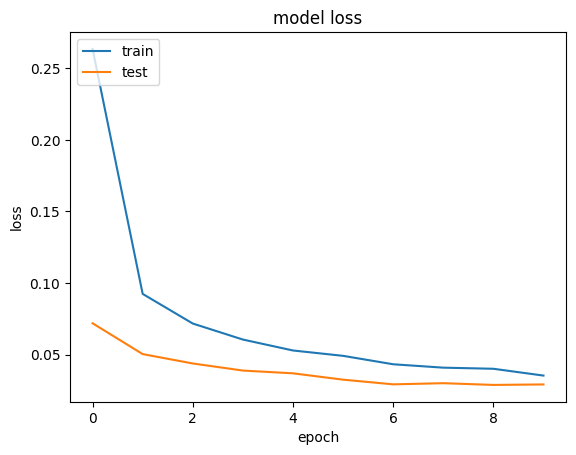

In [11]:
# check entries in the history 
print(history.history.keys()) # => dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [12]:
# Final evaluation of the model
scores = model.evaluate(
    x=X_test, 
    y=y_test, 
    verbose=0
)

print("\n[INFO] Model Val Accuracy: %.2f%%, Error: %.2f%%" % (scores[1]*100, 100-scores[1]*100))

2025-03-10 15:39:00.714853: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,26,26]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-10 15:39:00.739210: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,13,13]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=


[INFO] Model Val Accuracy: 99.01%, Error: 0.99%


__Test some demo images afetr training__

[INFO] Previous demo images... 


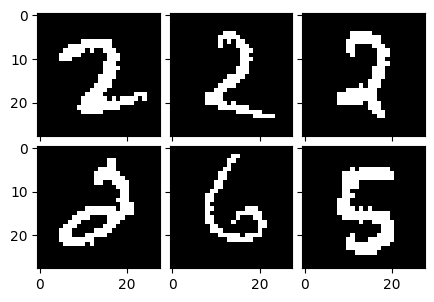

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[INFO] Prédictions:
 digit: 0 	 -  digit: 0 	 -  digit: 0 	 - 
 digit: 0 	 -  digit: 6 	 -  digit: 0 	 - 



In [35]:
# let's reuse the same previous demo settings...

print("[INFO] Previous demo images... ")
fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(nb_rows, nb_cols),
    axes_pad=0.1,
)

for ax, img in zip(grid, demo_imgs):
    ax.imshow(img)
plt.show()

# Now let's predict (again)
raw_predictions = model.predict(demo_imgs_arrays)

refined_predictions = []
for rp in raw_predictions:
    refined_predictions.append(np.argmax(rp))

print("[INFO] Prédictions:")

msg_pred = ""
cpt = 0
for i in range(nb_rows):
    for j in range(nb_cols):
        msg_pred += f" digit: {refined_predictions[cpt]} \t - "
        cpt += 1
    msg_pred += "\n"
    
print(msg_pred)

__END OF NOTEBOOK.__